## CV HOMEWORK

В данном задании вам будет нужно разработать простую систему OCR (optical char recognition) и в качестве допольнительного задания поиграться с переносом стиля между разными почерками.

Для решения задачи OCR мы постараемся задетектировать каждую букву, после чего отсортируем буквы слева направо и таким образом получим требуемое слово.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from pathlib import Path
from imageio import imread
import torch
import string
from utils import draw_umich_gaussian, gaussian_radius

import typing as tp

%matplotlib inline

### Данные

Для начала посмотрим на предоставленный датасет, предварительно скачав его по ссылке: https://drive.google.com/drive/folders/1J-wjzXPc9Nyb1WhHoTQSZfwBcXTU6Szh?usp=sharing


In [ ]:
dataset_path = Path('../ocr-train/syntetic_generators/new_generator/train_handwritten/')
ALPHABET = '0123456789()-+ '

with (dataset_path / 'markup.json').open('r') as f:
    markup = json.load(f)
    
for idx in np.random.choice(np.arange(len(markup)), 10):
    path, bboxes, labels, text = markup[idx]['image'], markup[idx]['bboxes'], markup[idx]['labels'], markup[idx]['text']
    image = imread(str(dataset_path / 'images' / path))
    
    for bbox in bboxes:
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=1)
    plt.imshow(image)
    plt.title(f"Text[{idx}]: {text}")
    plt.show()

В данном датасете используется формат "pascal_voc" для хранения боксов объектов

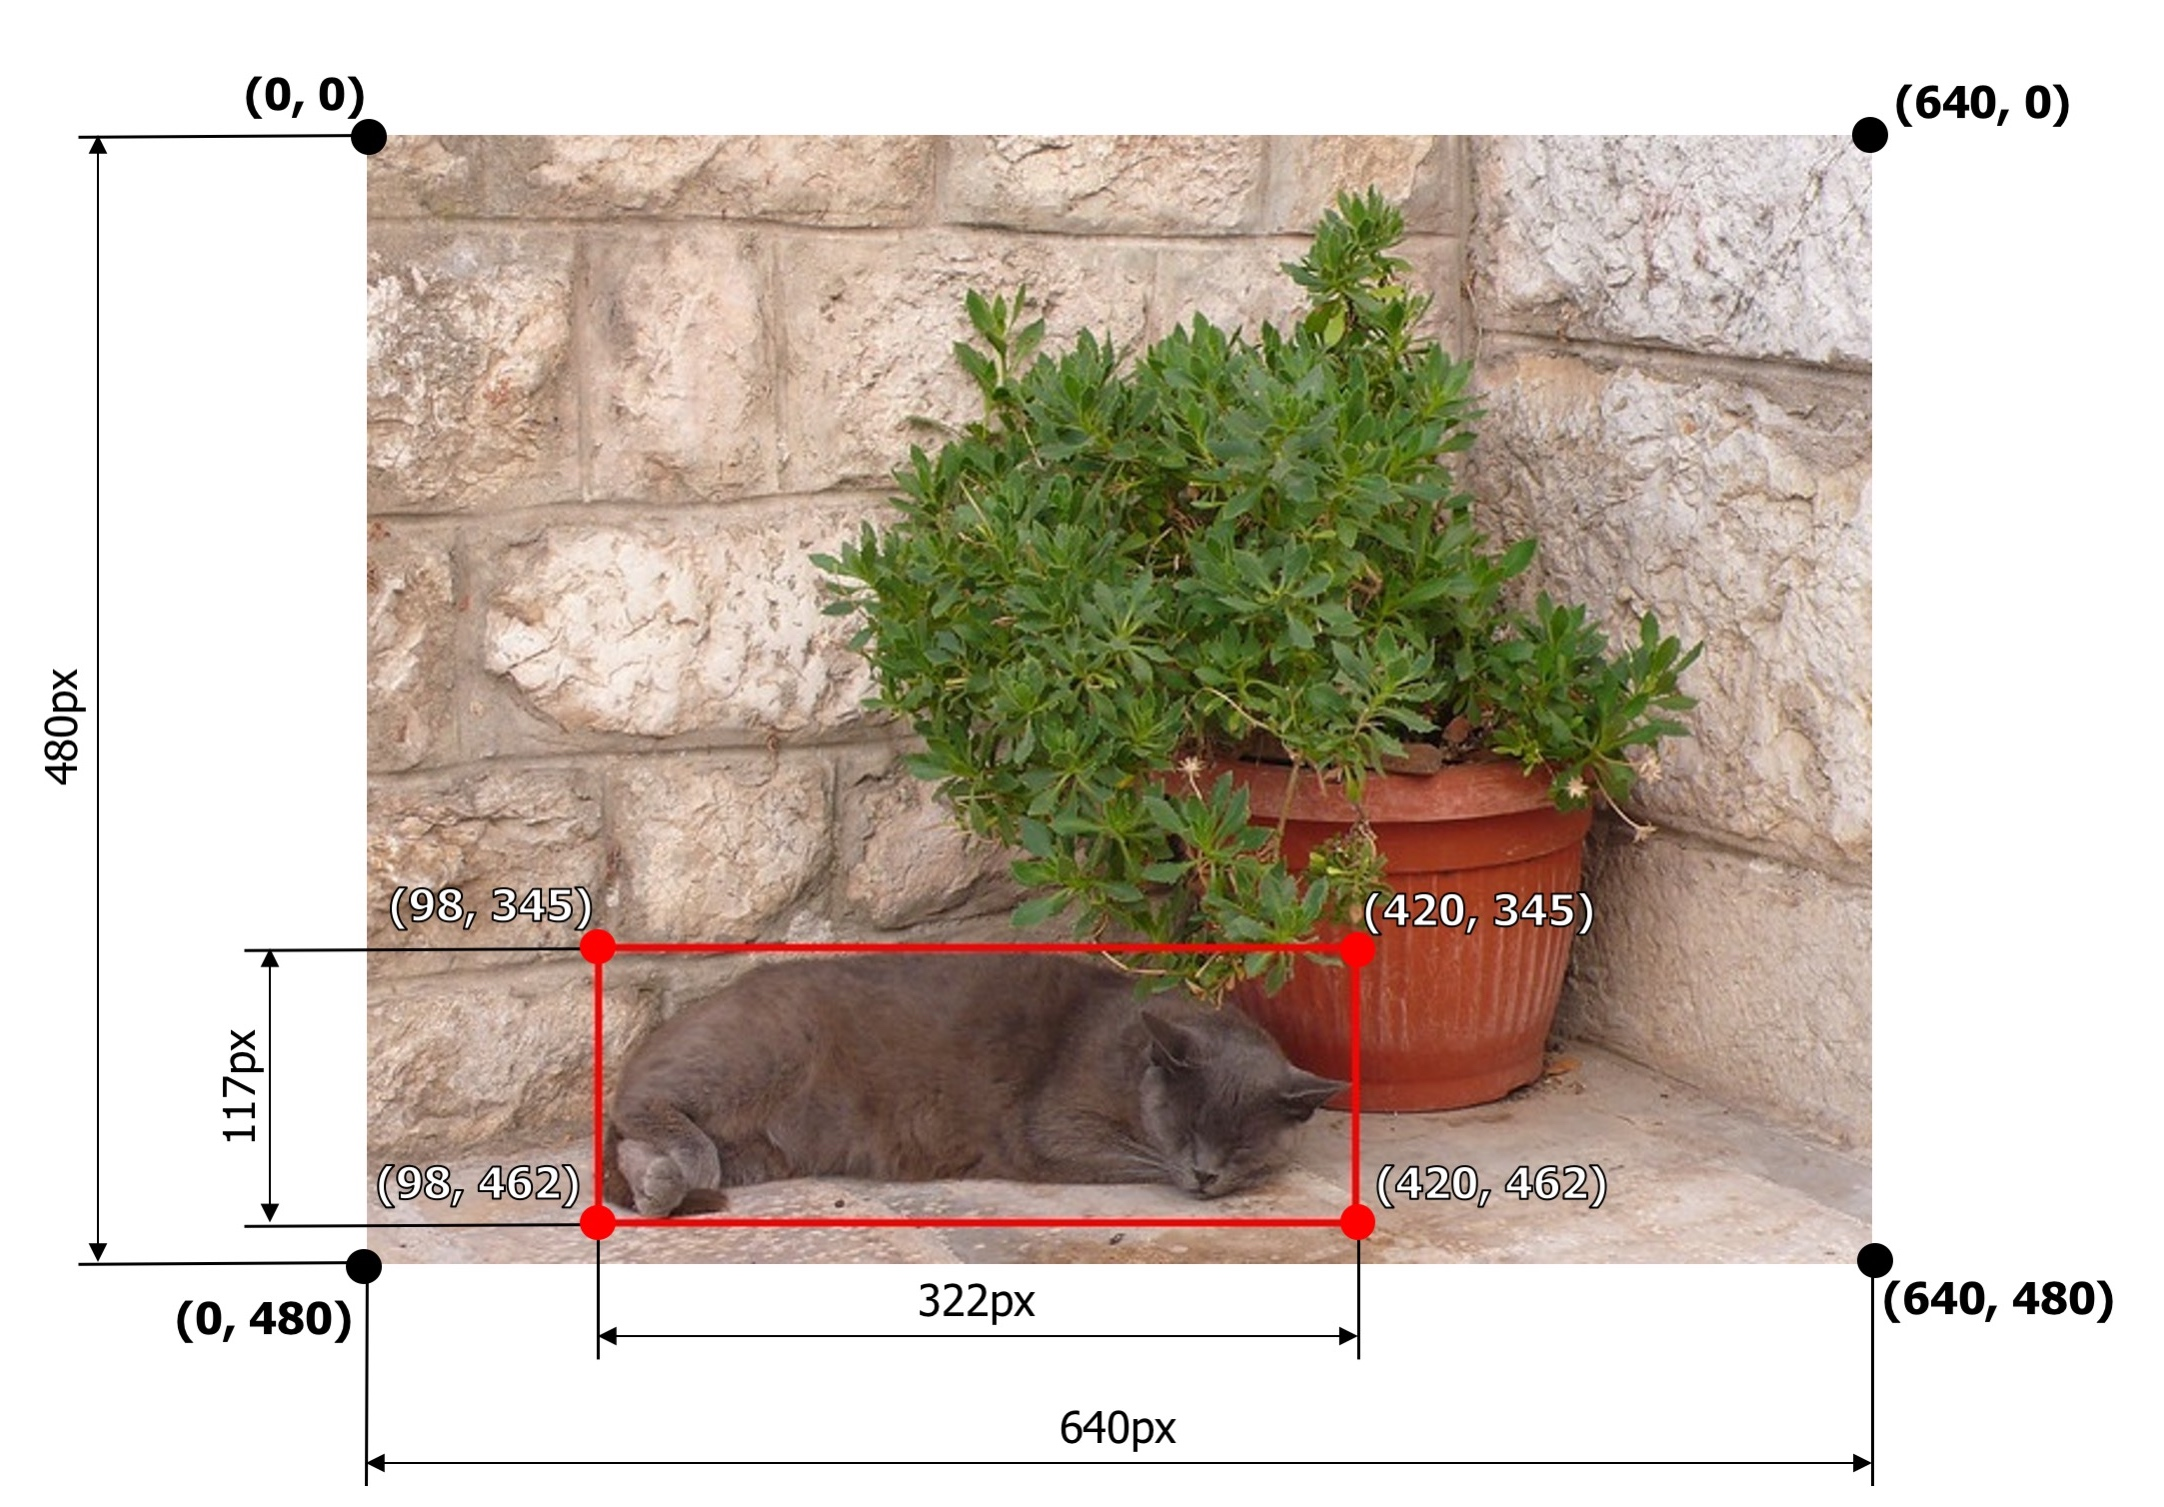

`pascal_voc` is a format used by the Pascal VOC dataset. Coordinates of a bounding box are encoded with four values in pixels: `[x_min, y_min, x_max, y_max]`. `x_min` and `y_min` are coordinates of the top-left corner of the bounding box. `x_max` and `y_max` are coordinates of bottom-right corner of the bounding box.

Coordinates of the example bounding box in this format are `[98, 345, 420, 462]`.

Метки букв же сохранены как символы в алфавите `0123456789()-+ `

In [ ]:
PARAMS = {
    'train_data_path': 'train_handwritten/',
    'test_data_path': 'test_handwritten/',
    'max_detections': 30,
    'batch_size': 16,
    'epochs': 20,
    'workers': 8,
    'device': 'cpu',
    'image_size': 224,
    
    # Место для возможности улучшения
    'weight-decay': 1e-5,
    'momentum': 0.9,
    'lr-step-size': 8,
    'lr-steps': [8, 11],
    'lr-gamma': 0.1,
    'lr': 1e-3,
    
    'output-dir': 'logs_example',
}

## Let's use simple centernet as default model

In [ ]:
from typing import Dict, Callable

import torch
import torch.nn as nn
from segmentation_models_pytorch import FPN


class CenterNet(nn.Module):
    def __init__(
        self,
        num_classes: int,
        embedding_dim: int = 32,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Место для возможности улучшения
        self.backbone = FPN(encoder_name='resnet18', 
                            encoder_weights='imagenet', 
                            in_channels=3, 
                            classes=embedding_dim
                            )
        
        self.head_heatmap = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=(3, 3), padding=1, bias=True),
            nn.ReLU6(),
            nn.Conv2d(embedding_dim, self.num_classes, kernel_size=(3, 3), padding=1, bias=True)
        )
      
        self.head_width_height = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=(3, 3), padding=1, bias=True),
            nn.ReLU6(),
            nn.Conv2d(embedding_dim, 2, kernel_size=(3, 3), padding=1, bias=True)
        )

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = self.backbone(x)
        value = {
            "hm": self.head_heatmap(features),
            "wh": self.head_width_height(features),
        }
        return value

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Место для возможности улучшения
transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=PARAMS['image_size']),
            A.PadIfNeeded(min_height=PARAMS['image_size'], min_width=PARAMS['image_size'], border_mode=0, value=0),
            A.Normalize(),
            ToTensorV2()
        ],
        bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=["labels"]),
)

In [ ]:
# Centernet requires dataset providing heatmaps for centers and feature maps for sizes
class OCRCenternetDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir: Path, transforms: A.Compose):
        self._data_dir = data_dir
        self._images_dir = data_dir / 'images'
        self._tranforms = transforms
        self._alphabet = ALPHABET
        self._char2index = {item: index for index, item in enumerate(self._alphabet)}
        self._categories = len(ALPHABET)
        self._max_detections = PARAMS['max_detections']
        
        with (self._data_dir / 'markup.json').open('r') as f:
            self._markup = json.load(f)
            
    def __getitem__(self, index: int) -> tp.Dict[str, torch.Tensor]:
        current_markup = self._markup[index]
        image = imread(str(self._images_dir / current_markup['image']))
        
        # Remove padding from images
        image_non_zero_columns = (image.sum(axis=0).sum(axis=1) != 0)
        left, right = 0, image.shape[1] - 1
        while not image_non_zero_columns[left] and left < right:
            left += 1
        while not image_non_zero_columns[right] and left < right:
            right -= 1
        image = image[:, image_non_zero_columns]
        
        bboxes = np.array(current_markup['bboxes'][:self._max_detections])
        bboxes[:, 0::2] -= left
        
        # Prevent intersection of image borders and bboxes
        h, w = image.shape[:2]
        
        bboxes[:, 0::2] = np.minimum(bboxes[:, 0::2], w - 1)
        bboxes[:, 1::2] = np.minimum(bboxes[:, 1::2], h - 1)
        bboxes = np.maximum(bboxes, 1)
        
        bboxes = [[x1, y1, x2, y2] for x1, y1, x2, y2 in bboxes if x1 < x2 and y1 < y2]
        
        labels = current_markup['labels'][:self._max_detections]
        
        pre_transformed = {
            'image': image,
            'bboxes': bboxes,
            'labels': labels
        }
        
        post_transformed = self._tranforms(**pre_transformed)
        
        # Heatmap for centers of letters
        heatmap_centers = np.zeros((self._categories, PARAMS['image_size'], PARAMS['image_size'])).astype(np.float32)
        heatmap_wh = np.zeros((2, PARAMS['image_size'], PARAMS['image_size'])).astype(np.float32)
        
        for label, (x1, y1, x2, y2) in zip(post_transformed['labels'], post_transformed['bboxes']):
            h, w = abs(y2 - y1), abs(x2 - x1)

            radius_to_draw = int(max(gaussian_radius((h, w)), 1))
            center_to_draw = int((x2 + x1) / 2), int((y2 + y1) / 2)
            
            draw_umich_gaussian(heatmap_centers[self._char2index[label]], center_to_draw, radius_to_draw)
            heatmap_wh[0, center_to_draw[1], center_to_draw[0]] = h
            heatmap_wh[1, center_to_draw[1], center_to_draw[0]] = w
            
        post_transformed['hm'] = torch.from_numpy(heatmap_centers)
        post_transformed['wh'] = torch.from_numpy(heatmap_wh)
        
        post_transformed['bboxes'] = torch.Tensor(post_transformed['bboxes'] 
                                                  + [[0, 0, 0, 0]] * (self._max_detections - len(post_transformed['bboxes'])))
        del post_transformed['labels']
        
        return post_transformed
        
    def __len__(self) -> int:
        return len(self._markup)
    
# Draw sample image with bboxes and heatmaps
sample_dataset = OCRCenternetDataset(Path(PARAMS['train_data_path']), transforms)
IDX = 1260

image = sample_dataset[IDX]['image'].numpy().transpose((1, 2, 0))
image -= image.min()
image /= (image.max() / 255)
image = image.astype(np.uint8)
for x1, y1, x2, y2 in sample_dataset[IDX]['bboxes']:
    image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)

plt.imshow(image)
plt.title('Sample image from dataset')
plt.show()

fig = plt.figure(figsize=(18, 3))
axes = fig.subplots(1, 5)
ax_idx = 0
for index, heatmap in enumerate(sample_dataset[IDX]['hm']):
    if heatmap.sum() != 0:
        axes[ax_idx].imshow(heatmap.numpy())
        axes[ax_idx].set_title(f"Heatmap for letter \'{ALPHABET[index]}\'")
        ax_idx += 1
    if ax_idx > 5:
        break
plt.show()

plt.imshow(sample_dataset[IDX]['wh'].sum(dim=0))
plt.title('WH maps for regression')
plt.show()

In [ ]:
def w_mse_loss(gt, prediction):
    error = (gt - prediction) ** 2
    error *= (np.abs(gt) + 0.2)
    return error.mean()

def masked_l2_loss(gt, prediction):
    error = (gt - prediction) ** 2
    
    # Место для возможности улучшения
    error *= (gt != 0).type(torch.float32)
    
    return error.mean()

### Переобучение

Чтобы убедиться, что модель реализована верно, в пропроцессинге данных нет ошибок и, что модель готова обучаться на больших данных ее для начала можно попытаться переобучить на одном батче и убедиться, что переобучение прошло успешно

In [ ]:
model = CenterNet(num_classes=len(ALPHABET))
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


train_dataset = OCRCenternetDataset(Path(PARAMS['train_data_path']), transforms)
sample_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
)

print('Example batch')
for batch in sample_loader:
    for key, value in batch.items():
        print(f"Shape for key={key} is {tuple(value.shape)} ({value.dtype})")
    break
    
    
train_loader = sample_loader
batch = next(iter(train_loader))

expected = torch.zeros(1, 15, 224, 224).type(torch.float32)
expected[:, :, :100] = 1

print('Start training')
for epoch in range(50):
    optimizer.zero_grad()
    
    if epoch == 15:
        for g in optimizer.param_groups:
            g['lr'] = 1e-4

    if epoch == 30:
        for g in optimizer.param_groups:
            g['lr'] = 1e-5

    model_predictions = model(batch['image'])

    # TODO find weights for different loss parts
    hm_loss = 10000 * w_mse_loss(batch['hm'], model_predictions['hm'])
    wh_loss = masked_l2_loss(batch['wh'], model_predictions['wh'])
    loss = hm_loss + wh_loss
    
    loss.backward()
    optimizer.step()
    
    # if epoch % 10 == 9:
    print('EPOCH:', epoch, '  HM:', hm_loss.item(), '  WH:', wh_loss.item())

In [ ]:
# We don't use model.eval() to check overfitting. Why?

# Let's draw predictions
predictions = model(batch['image'])

IDX = 0
fig = plt.figure(figsize=(18, 8))
axes = fig.subplots(1, 3)
axes[0].imshow(batch['image'][IDX].numpy().sum(axis=0))
axes[0].set_title('Image')

axes[1].imshow(predictions['hm'][IDX].detach().numpy().sum(axis=0))
axes[1].set_title('Centers')

axes[2].imshow(predictions['wh'][IDX].detach().numpy().sum(axis=0))
axes[2].set_title('Sizes')

plt.show()

Видим, что явно задетектировался центр одной из букв, но, возможно, не всех остальных. Почему?

### Задание

0. Реализуйте полный цикл обучения на всем датасете, а не на одном батче. Добавьте возможность учиться на гпу.
1. Добавьте аугментаций или подберите более оптимальные параметры обучения 
2. Самостоятельно придумайте, как последовательность гауссиан на выходе модели превратить в bounding boxes для уже обученной модели и получить сами предсказанные боксы букв
3. Посчитайте map на тренировочной и тестовой выборках для вашей модели
4. Посчитайте accuracy как метрику OCR на тренировочной и тестовой выборках. Accuracy - доля полностью правильно прочитанных слов


In [ ]:
model = CenterNet(num_classes=len(ALPHABET))
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['lr'], weight_decay=PARAMS['weight-decay'])


train_dataset = OCRCenternetDataset(Path(PARAMS['train_data_path']), transforms)
sample_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=PARAMS['batch_size'],
    shuffle=True,
)

# You should implement some validation code here

print('Example batch')
for batch in sample_loader:
    for key, value in batch.items():
        print(f"Shape for key={key} is {tuple(value.shape)} ({value.dtype})")
    break
    
    
# create samplers for train/val split
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=PARAMS['batch_size'],
    shuffle=False,
)


# Реализуйте train loop сомостоятельно, вам предоставлен лишь каркас
for epoch in range(PARAMS['epochs']):
    print(f"Epoch {epoch}")
    
    for batch in train_loader:
        break
        # optimizer...
        
        model_predictions = model(batch['image'])
        
        # TODO find weights for different loss parts
        # loss = 
        
        # loss....
        # optimizer...
        
        # print(...)
        
        # break # Useful to overfit your model
    break
    # Validate here